# Import required packages

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, cluster, manifold, decomposition

import sys
sys.path.append('./src')

from src.analyze import *

[nltk_data] Downloading package swadesh to
[nltk_data]     C:\Users\saumi\AppData\Roaming\nltk_data...
[nltk_data]   Package swadesh is already up-to-date!


## Import translation data and list of languages with their families

In [2]:
#Translation data in latin script
data = pd.read_csv('./data/data-latin.csv', index_col=0).fillna('')

#List of languages amnd families
languages = pd.read_csv('./data/languages.csv', index_col=0)

#Separate language family into sub-categories
languages.loc['major_family'] = languages.loc['family'].apply(lambda x: x.split(',')[0])
languages.loc['sub_family'] = languages.loc['family'].apply(lambda x: x.split(',')[1] if x.split(',')[0]=='Indo-European' else x.split(',')[0])

# Visualize known language families

## Histogram of families

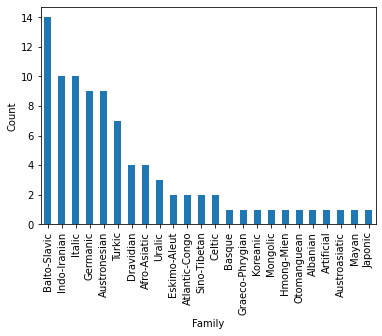

In [3]:
labels = languages.loc['name'].T.to_frame()
labels['family'] = languages.loc['sub_family']

labels['family'].value_counts().plot(kind='bar')
plt.xticks(rotation=90);
plt.ylabel('Count')
plt.xlabel('Family');

## Statistics of language families

In [8]:
print('The number of languages is', len(languages.columns))
print('The number of families we will use for classifying is', len(labels['family'].value_counts()))

The number of languages is 89
The number of families we will use for classifying is 24


We see that there are 89 languages and 24 families. So on average, every group has only 3-4 languages. 

However, the histogram tells us that there are a few families with around 10 languages and some with only onle language. So the cluster size can be quite variable!

## Let's visualize the languages and their labels through a word cloud

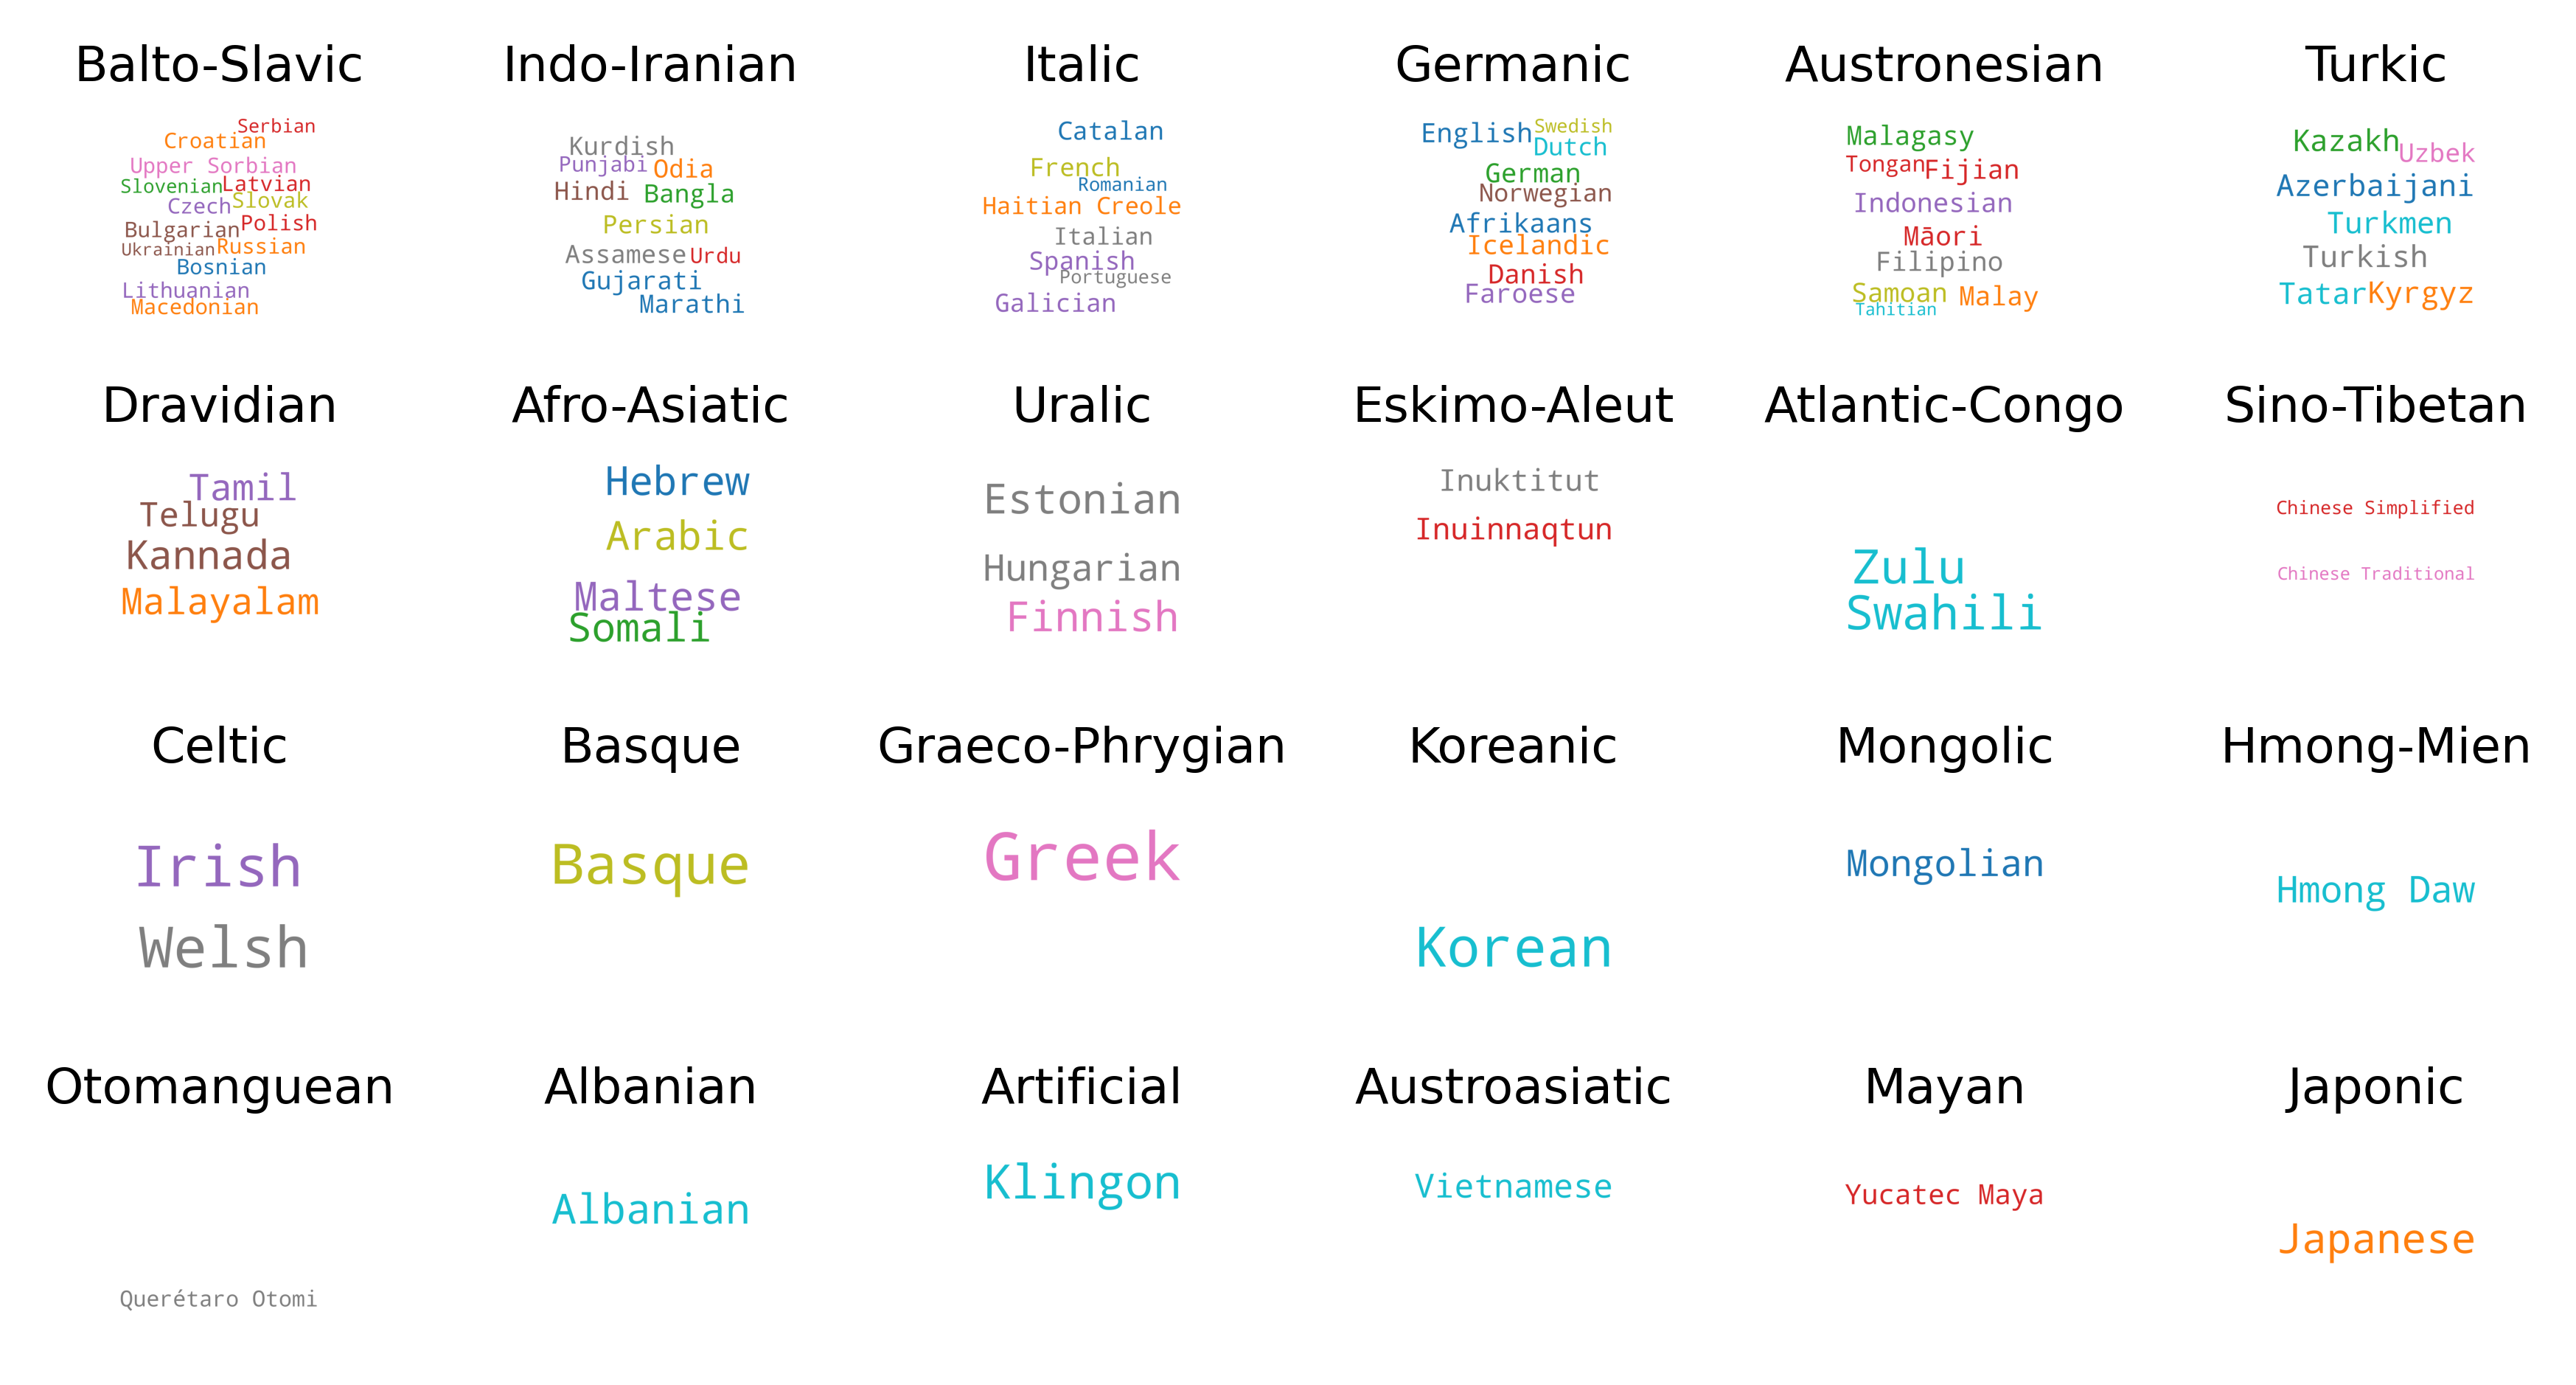

In [12]:
fig = plot_language_groups(labels);

Now it's time to start analyzing the translation data to see if can figure out the relationship between languages!

# Analysis on distances from english

To start with, let's start by measuring the similarity of the translation for each word to a reference language, English (say). To measure the distance between strings, we can use the Levenshtein or edit distance that tells us how many insertions and deletions we need to get one word from another. This is available in NLTK!

In [14]:
#Get distances from crresponding english word for each word, language pair
distances_from_english = data.T.apply(lambda x: dist_to_word(x, x.name))

print('Shape of the data is', distances_from_english.shape)

Shape of the data is (89, 288)


We now have a dataset where each row is a language and each column is the edit distance of the translation of a specific word in that language to english. The columns are like features. We notice that there are more features than instances. This is not ideal for clustering

## PCA followed by k-means clustering

Let's start with some dimensional reduction using PCA followed by a simple K-means clustering. Let's try to optimize for the number of dimensions kept in PCA and clusters by scoring the clustering algorithm against the known language families

### Grid search over number of components and number of clusters

In [ ]:
pca = decomposition.PCA()
X = pca.fit_transform(distances_from_english)

results = []

for n_clusters in [12, 16, 18, 20, 22, 24, 30]:
    for n_components in [10, 20, 30, 40, 80]:

        print("="*100)
        
        print('Number of PCA components = {}, Number of KMeans clusters = {}'.format(n_components, n_clusters))

        kmeans = cluster.KMeans(n_clusters=n_clusters, n_init=200)

        kmeans.fit(X[:, :n_components])

        scores = score_model(kmeans.labels_, languages.loc['sub_family'])

        d = {'n_components':n_components, 'n_clusters':n_clusters}
        d.update(scores)

        results.append(d)

results = pd.DataFrame(results)

Number of PCA components = 10, Number of KMeans clusters = 12
Number of PCA components = 20, Number of KMeans clusters = 12
Number of PCA components = 30, Number of KMeans clusters = 12
Number of PCA components = 40, Number of KMeans clusters = 12
Number of PCA components = 80, Number of KMeans clusters = 12
Number of PCA components = 10, Number of KMeans clusters = 16
Number of PCA components = 20, Number of KMeans clusters = 16
Number of PCA components = 30, Number of KMeans clusters = 16
Number of PCA components = 40, Number of KMeans clusters = 16
Number of PCA components = 80, Number of KMeans clusters = 16
Number of PCA components = 10, Number of KMeans clusters = 18
Number of PCA components = 20, Number of KMeans clusters = 18
Number of PCA components = 30, Number of KMeans clusters = 18
Number of PCA components = 40, Number of KMeans clusters = 18
Number of PCA components = 80, Number of KMeans clusters = 18
Number of PCA components = 10, Number of KMeans clusters = 20
Number o

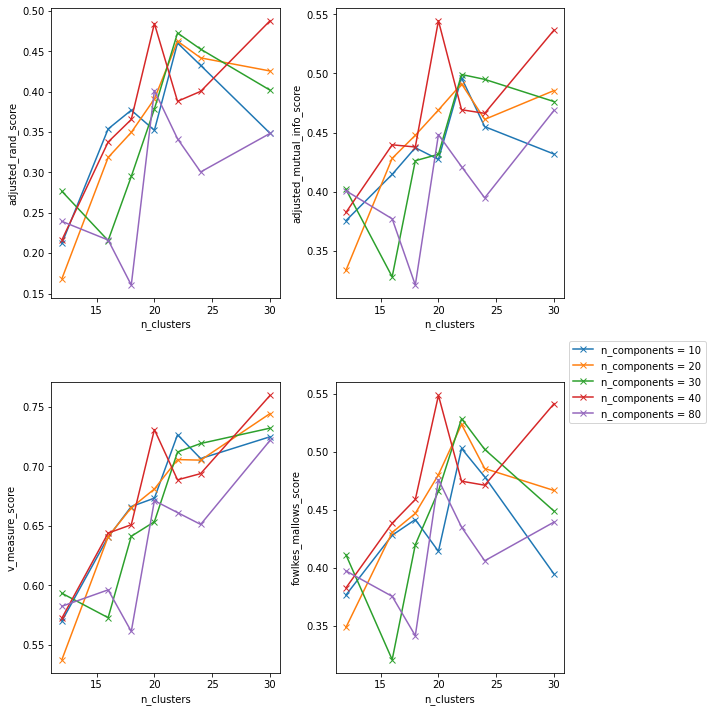

In [ ]:
group = results.groupby(['n_components'])

score_name = ['adjusted_rand_score', 'adjusted_mutual_info_score', 'v_measure_score', 'fowlkes_mallows_score']

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, name in enumerate(score_name):
    for key, df in group:
        ax[i//2, i%2].plot(df['n_clusters'], df[name], label='n_components = {}'.format(key), marker='x')
    
    ax[i//2, i%2].set_xlabel('n_clusters')
    ax[i//2, i%2].set_ylabel(name)

plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    
plt.tight_layout()

Around 20-40 components with around 20 clusters is optimal

### Visualize the groups for the best fit

num components = 40.0, num clusters = 30.0


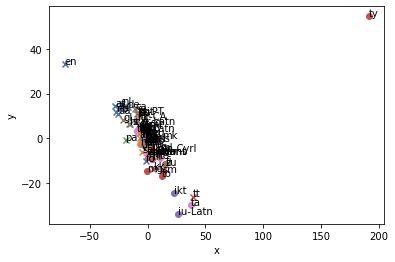

In [ ]:
best_params = results.iloc[results['adjusted_rand_score'].argmax()]

print('num components = {}, num clusters = {}'.format(best_params['n_components'], best_params['n_clusters']))

kmeans = cluster.KMeans(n_clusters=int(best_params['n_clusters']), n_init=200)

kmeans.fit(X[:, :int(best_params['n_components'])])

x, y = X[:, :2].T

plot_languages(x, y, labels=languages.loc['sub_family'], languages=languages.columns);

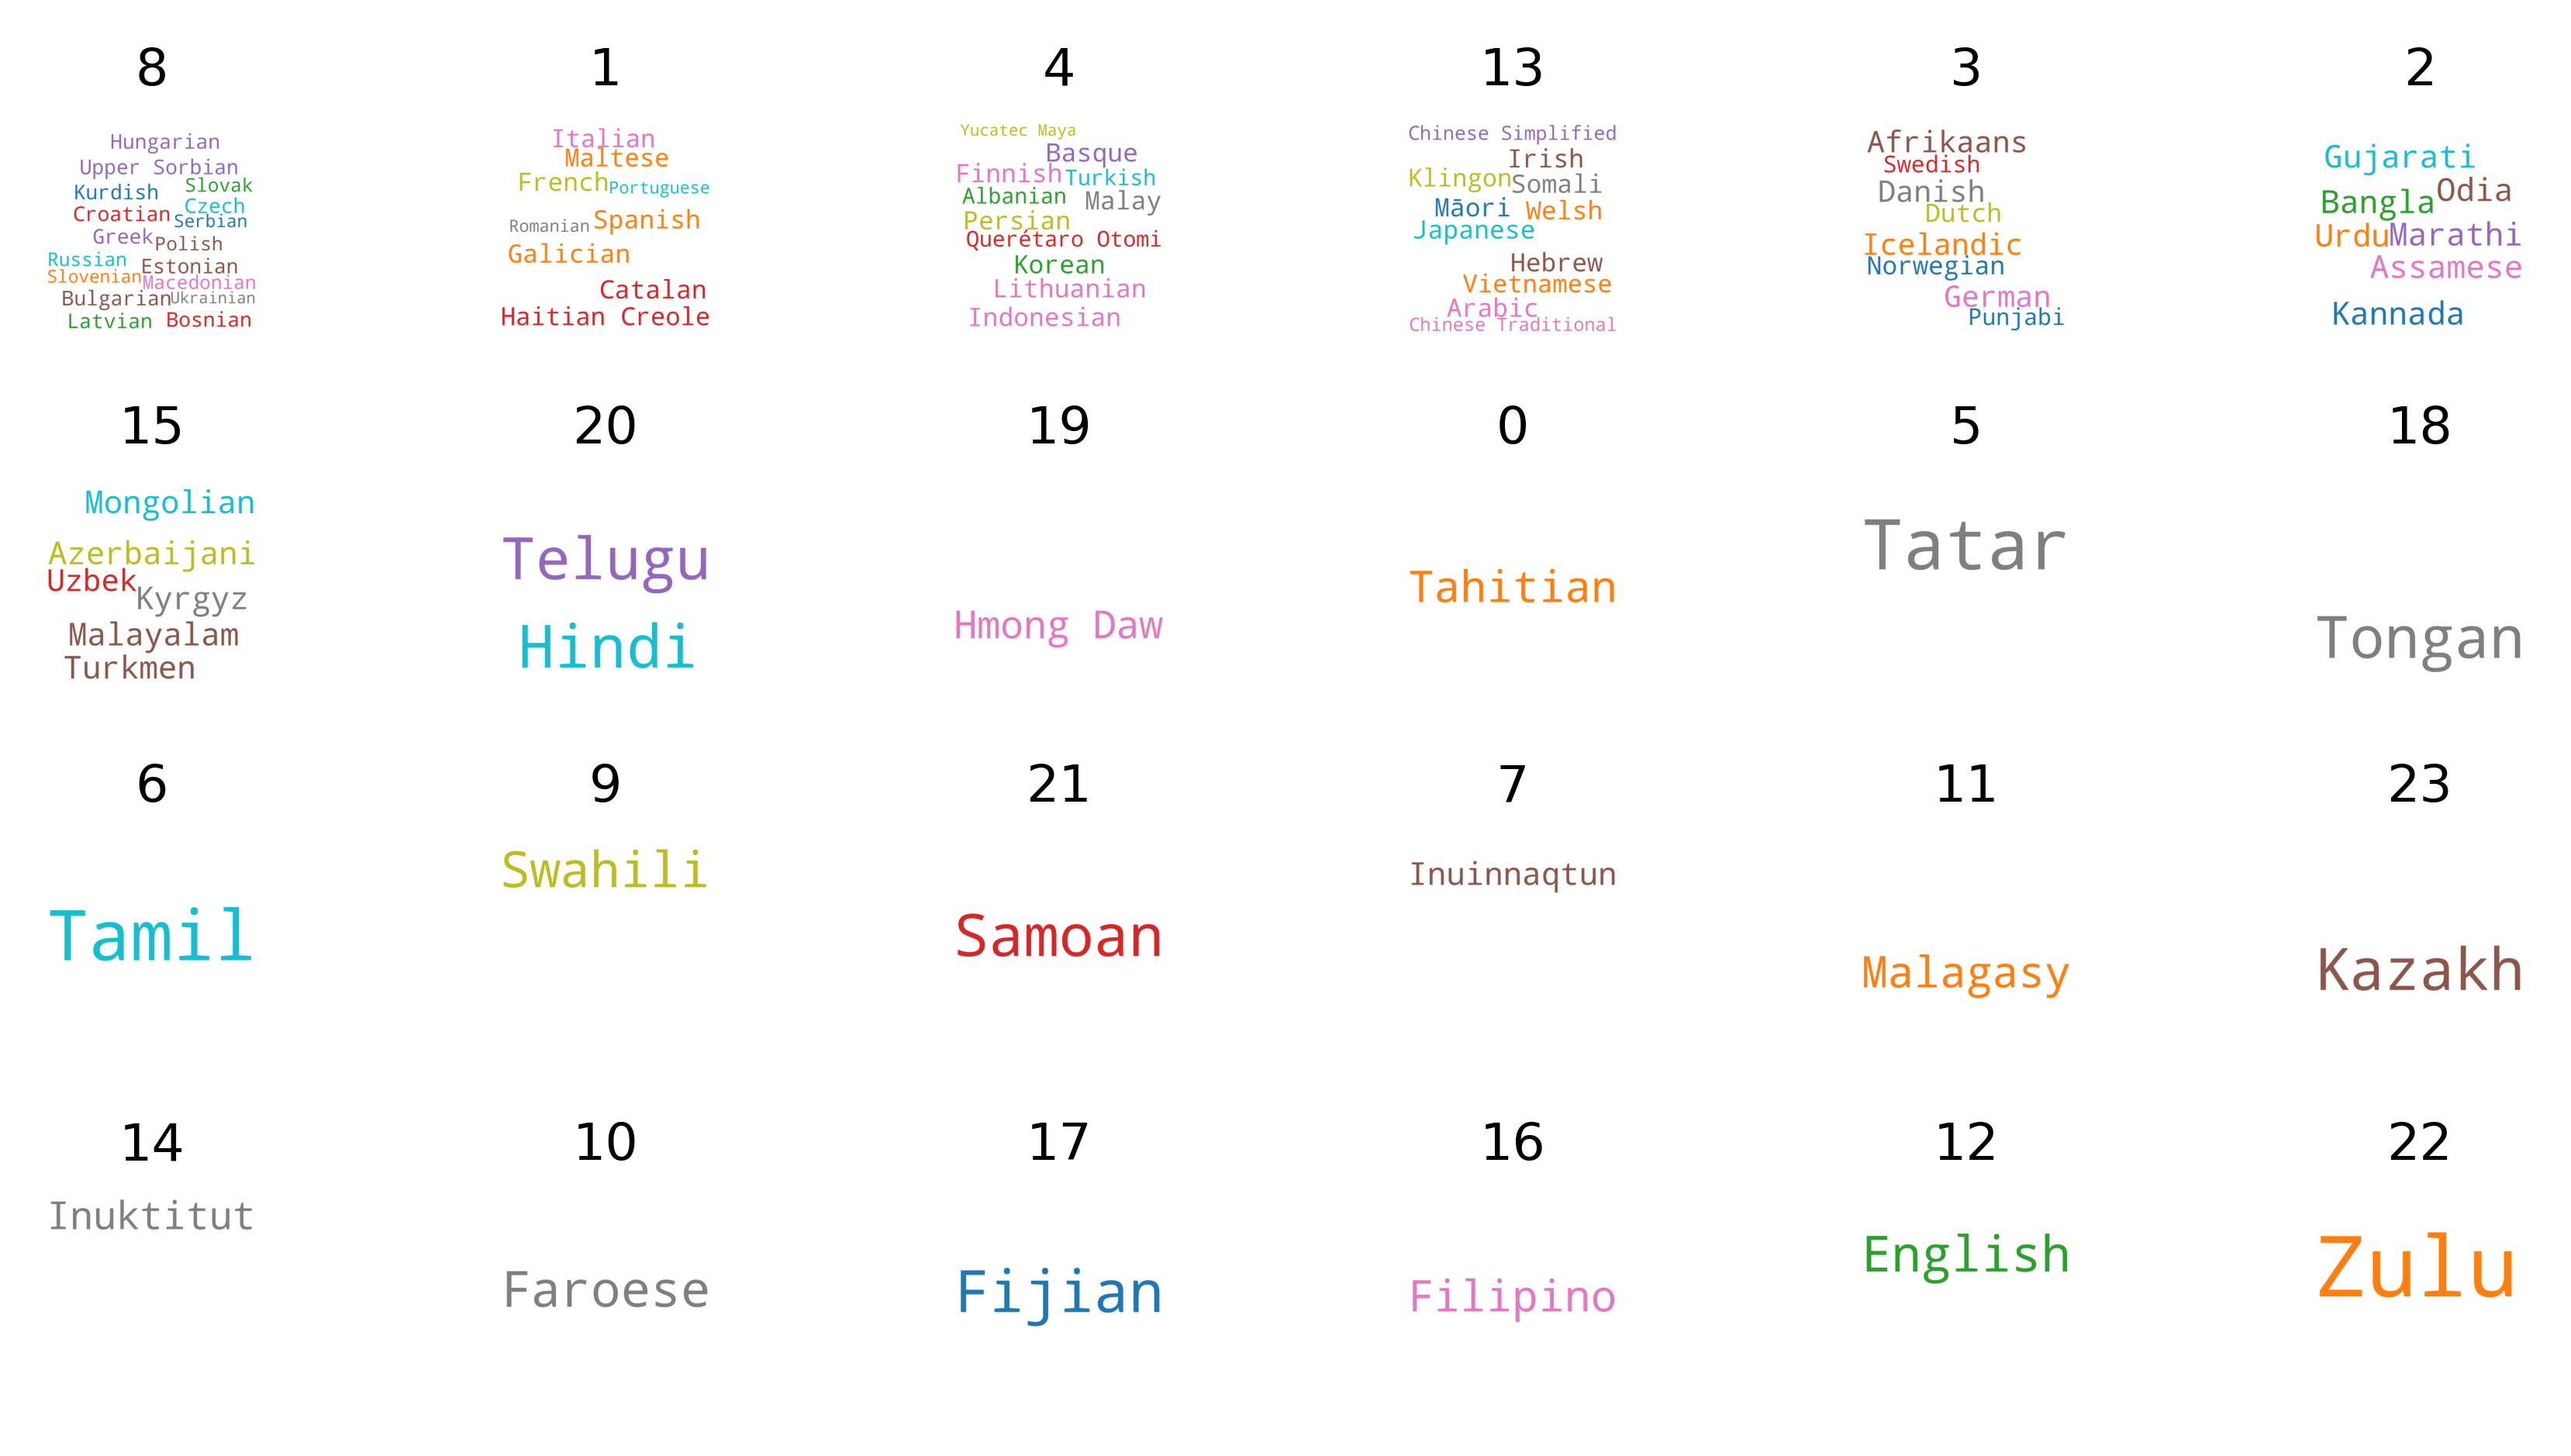

In [ ]:
labels = pd.DataFrame({'name':languages.loc['name'], 'family':kmeans.labels_})

plot_language_groups(labels);

We do well with the Balto-Slavic, Italian, Germanic, and Indo-Iranian languages. Not good enough for the rest

## Kernel PCA foolowed by KMeans

### Grid search over number of components and number of clusters

In [ ]:
results = []

for gamma in [0.0002, 0.0006, 0.001, 0.004]:
    for n_clusters in [16, 18, 20, 22, 24, 30, 40]:

        kpca = decomposition.KernelPCA(n_components=30, kernel='rbf', gamma=gamma)
        X = kpca.fit_transform(distances_from_english)

        print("="*100)
        
        print('Gamma = {}, Number of KMeans clusters = {}'.format(gamma, n_clusters))

        kmeans = cluster.KMeans(n_clusters=n_clusters, n_init=200)

        kmeans.fit(X)

        scores = score_model(kmeans.labels_, languages.loc['sub_family'])

        d = {'gamma':gamma, 'n_clusters':n_clusters}
        d.update(scores)

        results.append(d)

results = pd.DataFrame(results)

Gamma = 0.0002, Number of KMeans clusters = 16
Gamma = 0.0002, Number of KMeans clusters = 18
Gamma = 0.0002, Number of KMeans clusters = 20
Gamma = 0.0002, Number of KMeans clusters = 22
Gamma = 0.0002, Number of KMeans clusters = 24
Gamma = 0.0002, Number of KMeans clusters = 30
Gamma = 0.0002, Number of KMeans clusters = 40
Gamma = 0.0006, Number of KMeans clusters = 16
Gamma = 0.0006, Number of KMeans clusters = 18
Gamma = 0.0006, Number of KMeans clusters = 20
Gamma = 0.0006, Number of KMeans clusters = 22
Gamma = 0.0006, Number of KMeans clusters = 24
Gamma = 0.0006, Number of KMeans clusters = 30
Gamma = 0.0006, Number of KMeans clusters = 40
Gamma = 0.001, Number of KMeans clusters = 16
Gamma = 0.001, Number of KMeans clusters = 18
Gamma = 0.001, Number of KMeans clusters = 20
Gamma = 0.001, Number of KMeans clusters = 22
Gamma = 0.001, Number of KMeans clusters = 24
Gamma = 0.001, Number of KMeans clusters = 30
Gamma = 0.001, Number of KMeans clusters = 40
Gamma = 0.004, Numbe

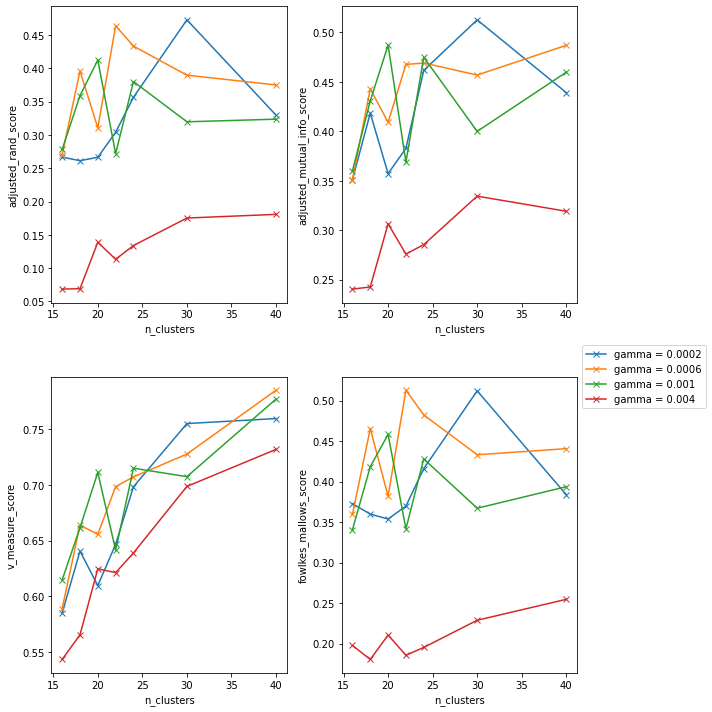

In [ ]:
group = results.groupby(['gamma'])

score_name = ['adjusted_rand_score', 'adjusted_mutual_info_score', 'v_measure_score', 'fowlkes_mallows_score']

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, name in enumerate(score_name):
    for key, df in group:
        ax[i//2, i%2].plot(df['n_clusters'], df[name], label='gamma = {}'.format(key), marker='x')
    
    ax[i//2, i%2].set_xlabel('n_clusters')
    ax[i//2, i%2].set_ylabel(name)

plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    
plt.tight_layout()

The results are not better than using PCA

## PCA Followed by Mean shift

Most other methods use pairwise distances so it's better to work without computing distance to english

In [ ]:
pca = decomposition.PCA()
X = pca.fit_transform(distances_from_english)

results = []

for bw in [5, 10, 12, 14, 16, 18, 20, 25, 30]:
    for n_components in [20, 30, 40]:

        print("="*100)
        
        print('Number of PCA components = {}, Bandwidth = {}'.format(n_components, bw))

        ms = cluster.MeanShift(bandwidth=bw)

        ms.fit(X[:, :n_components])

        scores = score_model(ms.labels_, languages.loc['sub_family'])

        d = {'n_components':n_components, 'bandwidth':bw}
        d.update(scores)

        results.append(d)

results = pd.DataFrame(results)

Number of PCA components = 20, Bandwidth = 5
Number of PCA components = 30, Bandwidth = 5
Number of PCA components = 40, Bandwidth = 5
Number of PCA components = 20, Bandwidth = 10
Number of PCA components = 30, Bandwidth = 10
Number of PCA components = 40, Bandwidth = 10
Number of PCA components = 20, Bandwidth = 12
Number of PCA components = 30, Bandwidth = 12
Number of PCA components = 40, Bandwidth = 12
Number of PCA components = 20, Bandwidth = 14
Number of PCA components = 30, Bandwidth = 14
Number of PCA components = 40, Bandwidth = 14
Number of PCA components = 20, Bandwidth = 16
Number of PCA components = 30, Bandwidth = 16
Number of PCA components = 40, Bandwidth = 16
Number of PCA components = 20, Bandwidth = 18
Number of PCA components = 30, Bandwidth = 18
Number of PCA components = 40, Bandwidth = 18
Number of PCA components = 20, Bandwidth = 20
Number of PCA components = 30, Bandwidth = 20
Number of PCA components = 40, Bandwidth = 20
Number of PCA components = 20, Bandwi

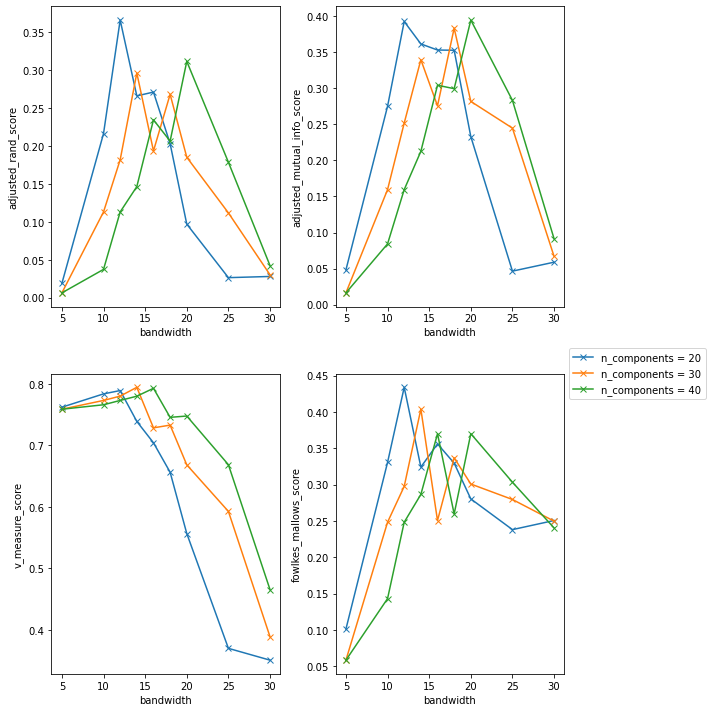

In [ ]:
group = results.groupby(['n_components'])

score_name = ['adjusted_rand_score', 'adjusted_mutual_info_score', 'v_measure_score', 'fowlkes_mallows_score']

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, name in enumerate(score_name):
    for key, df in group:
        ax[i//2, i%2].plot(df['bandwidth'], df[name], label='n_components = {}'.format(key), marker='x')
    
    ax[i//2, i%2].set_xlabel('bandwidth')
    ax[i//2, i%2].set_ylabel(name)

plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    
plt.tight_layout()

Does not perform better than PCA->KMeans